## load data, clip to land

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.lines as mlines

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'soil_moisture_l1'
SM_level = 'Level 1'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['moisture_content_of_soil_layer']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['moisture_content_of_soil_layer']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['moisture_content_of_soil_layer']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['moisture_content_of_soil_layer']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['moisture_content_of_soil_layer']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['moisture_content_of_soil_layer']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['moisture_content_of_soil_layer']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['moisture_content_of_soil_layer']

In [3]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

In [4]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

# movement over time

In [5]:
#clipping to fires
experiments = {
    "All variables": allvar,
    "Control": control,
    "Albedo + bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + albedo": SM_albedo,
    "SM + bare": SM_bare,
    "SM": SM
}

fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da

In [6]:
allvar_f = clipped['All variables']
control_f =clipped['Control']
albedo_bare_f =clipped['Albedo + bare']
albedo_f =clipped['Albedo']
bare_f =clipped['Bare']
SM_albedo_f =clipped['SM + albedo']
SM_bare_f =clipped['SM + bare']
SM_f =clipped['SM']

In [7]:
#fire dict
experiments_f = {
    "All Variables": allvar_f,
    "Control": control_f,
    "Albedo + Bare": albedo_bare_f,
    "Albedo": albedo_f,
    "Bare": bare_f,
    "SM + Albedo": SM_albedo_f,
    "SM + Bare": SM_bare_f,
    "SM": SM_f
}

## absolute SM

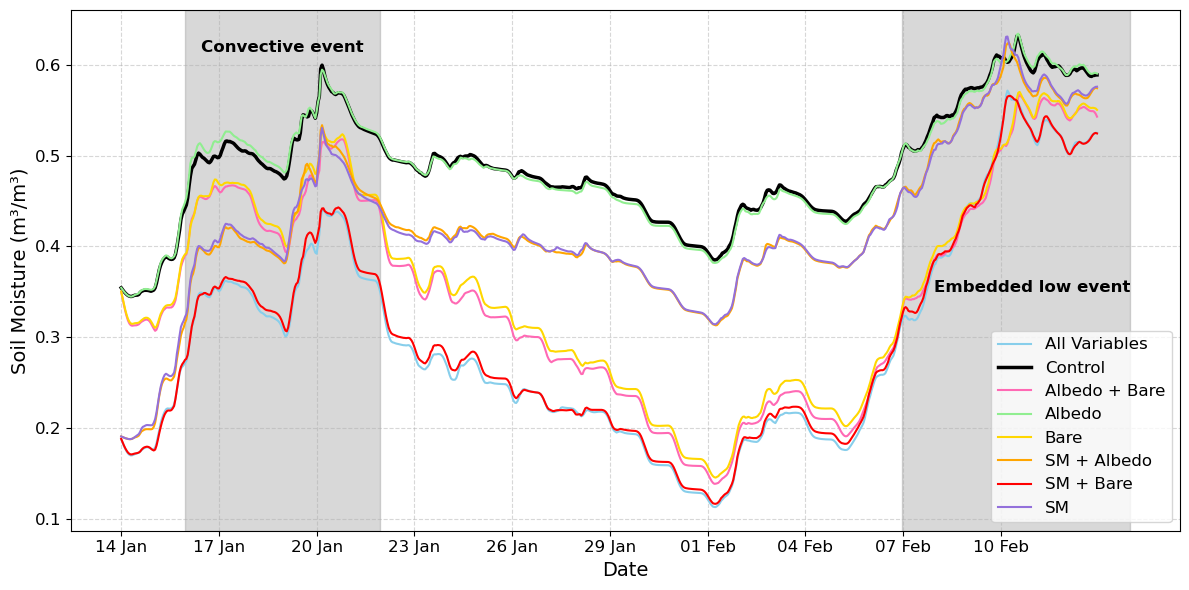

In [8]:
#absolute SM
colors = ["skyblue", "black", "hotpink", "lightgreen", "gold", 
          "orange", "red", "mediumpurple"]

plt.figure(figsize=(12,6))

for i, (name, da) in enumerate(experiments_f.items()):
    #spatial mean
    time_series = da.mean(dim=["latitude","longitude"], skipna=True)
    dates_aest = pd.to_datetime(time_series.time.values) + pd.Timedelta(hours=10)

    #make Control line thicker
    if name == "Control":
        plt.plot(dates_aest, time_series, label=name, color="black", linewidth=2.5)
    else:
        plt.plot(dates_aest, time_series, label=name, color=colors[i % len(colors)], linewidth=1.5)

#highlight events
#embedded low
plt.axvspan(pd.to_datetime("2020-02-07 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-02-13 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-02-08 00:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.55, "Embedded low event", va="top", ha="left", fontsize=12, color="black", weight="demi")
#convective 
plt.axvspan(pd.to_datetime("2020-01-16 00:00") + pd.Timedelta(hours=10),
            pd.to_datetime("2020-01-21 23:59") + pd.Timedelta(hours=10),
            color="grey", alpha=0.3)
plt.text(pd.to_datetime("2020-01-16 12:00") + pd.Timedelta(hours=10),
         plt.ylim()[1]*0.95, "Convective event", va="top", ha="left", fontsize=12, color="black", weight="demi")

plt.ylabel("Soil Moisture (m³/m³)", fontsize=14)
plt.xlabel("Date", fontsize = 14)
# plt.title(f"{SM_level} Hourly Soil Moisture (fire scars)")
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.xticks(
    ticks=dates_aest[::max(1, len(dates_aest)//10)],
    labels=[d.strftime("%d %b") for d in dates_aest[::max(1, len(dates_aest)//10)]],
    rotation=0, fontsize=12
)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("/g/data/ng72/as9583/new_analysis/figures/SM_lev1_hourly_raw.png", dpi=300, bbox_inches="tight")
plt.show()
